## Open Classification with CNN model

In [102]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline
import matplotlib.pyplot as plt

import os, sys, re, json, time, shutil
import itertools, collections
from IPython.display import display, HTML
from collections import Counter

# NLTK for NLP utils and corpora
import nltk
from sklearn.metrics import classification_report, accuracy_score

# NumPy and TensorFlow
import numpy as np
import tensorflow as tf
assert(tf.__version__.startswith("1.1"))

# utils.pretty_print_matrix uses Pandas. Configure float format here.
import pandas as pd
pd.set_option('float_format', lambda f: "{0:.04f}".format(f))

# Helper libraries
from shared_lib import utils, vocabulary, tf_embed_viz

import copy

# Import model
#import cnnlm
reload(utils)

<module 'shared_lib.utils' from 'shared_lib/utils.pyc'>

In [103]:
## Load SKlearn libraries
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from sklearn.svm import SVC
from sklearn.grid_search import GridSearchCV
from sklearn import metrics
from sklearn.metrics import f1_score

In [104]:
DATA_DIR = 'Data_Set/'
PROJECT_PATH = os.getcwd()
PROJECT_DATA = os.path.join(PROJECT_PATH, DATA_DIR)

## Load Data Set

In [105]:
# SK-learn library for importing the newsgroup data.
from sklearn.datasets import fetch_20newsgroups

# Get newsgroup data
newsgroup_data_all = fetch_20newsgroups(subset = 'all', remove=('headers', 'footers', 'quotes'))
all_data, all_labels = newsgroup_data_all.data, newsgroup_data_all.target

# List of all the class labels
label_list = list(newsgroup_data_all.target_names)

# Print the class labels
i = 0
for label in label_list:
    print "class: %i\t = %s" %(i, label)
    i += 1

class: 0	 = alt.atheism
class: 1	 = comp.graphics
class: 2	 = comp.os.ms-windows.misc
class: 3	 = comp.sys.ibm.pc.hardware
class: 4	 = comp.sys.mac.hardware
class: 5	 = comp.windows.x
class: 6	 = misc.forsale
class: 7	 = rec.autos
class: 8	 = rec.motorcycles
class: 9	 = rec.sport.baseball
class: 10	 = rec.sport.hockey
class: 11	 = sci.crypt
class: 12	 = sci.electronics
class: 13	 = sci.med
class: 14	 = sci.space
class: 15	 = soc.religion.christian
class: 16	 = talk.politics.guns
class: 17	 = talk.politics.mideast
class: 18	 = talk.politics.misc
class: 19	 = talk.religion.misc


In [106]:
from nltk.corpus import PlaintextCorpusReader

f = open('./Data_Set/newsgroup_prep/newsgroup_all.txt', 'w') 
for doc in all_data:
    # Clean up str
    doc = utils.clean_str((doc).encode('utf-8'))
    # remove stop words and do stemming optionaly
    doc = utils.preprocess_stop_stem(doc, stop=True, sent=True, stem=False)
    f.write("%s\n" %(doc))
f.close()

# RegEx or list of file names
data_20newsgroup = os.path.join(PROJECT_DATA, 'newsgroup_prep/')

corpus = PlaintextCorpusReader(data_20newsgroup, 'newsgroup_all.txt')

for infile in sorted(corpus.fileids()):
    print infile # The fileids of each file.

newsgroup_all.txt


In [107]:
V = 20000
vocab = vocabulary.Vocabulary((utils.canonicalize_word(w) 
                               for w in utils.flatten(corpus.sents())),
                               size = V)
print "Vocabulary: %d words" % vocab.size

Vocabulary: 20000 words


In [108]:
# Select training and test data based on the number of classes
# Including randomization option
import random
from random import randint
random.seed(8)

num_class = 8
randomize = True

if randomize == True:
    label_idxs = []
    label_idxs = random.sample(range(1, 19), num_class)
else:
    label_idxs = range(num_class)

select_classes = [label_list[i] for i in label_idxs]
print "Randomly Select Classes: ", select_classes

newsgroups_all = fetch_20newsgroups(subset='all', remove=('headers', 'footers', 'quotes'),
                                    categories=select_classes)

all_data, all_labels = newsgroups_all.data, newsgroups_all.target
print np.unique(all_labels)

Randomly Select Classes:  ['comp.windows.x', 'talk.politics.mideast', 'comp.sys.ibm.pc.hardware', 'sci.crypt', 'comp.os.ms-windows.misc', 'comp.sys.mac.hardware', 'sci.electronics', 'talk.politics.guns']
[0 1 2 3 4 5 6 7]


In [109]:
doc_length = 500

# Preprocess data
# Cleaning special characters
# Cut or pad based on document length
all_docs = utils.preprocess_doc(all_data, length = doc_length)

# Split total data set to training and test set
train_docs, train_labels, test_docs, test_labels = utils.get_train_test_docs(all_docs, 
                                                                             all_labels, 
                                                                             split = 0.8, 
                                                                             shuffle = True)
orig_test_labels = copy.copy(test_labels)

Loaded 7743 docs (2.36154e+07 tokens)
Training set: 6194 docs (18888526 tokens)
Test set: 1549 docs (4726834 tokens)


In [110]:
# Tokenize documents and conver to ID
# We tokenize each docs in the dataset and convert to vocab ID
# matrix of batch_size x doc_length
train_docs_ids = utils.docs_to_ids(train_docs, vocab)
test_docs_ids = utils.docs_to_ids(test_docs, vocab)

# Convert label to one-hot-code
train_labels_oh = np.eye(num_class)[train_labels]
test_labels_oh = np.eye(num_class)[test_labels]


print "Input Training Docs shape:", train_docs_ids.shape, "should equal to (batch_size, doc_length)"
print "Input Training labels shape:", train_labels_oh.shape, "should equal to (batch_size, num_class)"
print "Input Testing Docs shape:", test_docs_ids.shape, "should equal to (batch_size, doc_length)"
print "Input Testing labels shape:", test_labels_oh.shape, "should equal to (batch_size, num_class)"

Input Training Docs shape: (6194, 500) should equal to (batch_size, doc_length)
Input Training labels shape: (6194, 8) should equal to (batch_size, num_class)
Input Testing Docs shape: (1549, 500) should equal to (batch_size, doc_length)
Input Testing labels shape: (1549, 8) should equal to (batch_size, num_class)


### Load Pretrained Google Word2vec

In [111]:
def load_google_bin(fname, vocab):
    """
    Loads 300x1 word vecs from Google (Mikolov) word2vec
    """
    word_vecs = {}
    with open(fname, "rb") as f:
        header = f.readline()
        vocab_size, layer1_size = map(int, header.split())
        print "Google Word2vec Vocabulary Size:", vocab_size
        print "Vector size:", layer1_size
        binary_len = np.dtype('float32').itemsize * layer1_size
        print "Binary Length of word vector:", binary_len
        for line in xrange(vocab_size):
            word = []
            while True: # Read 1 char a time
                ch = f.read(1) 
                if ch == ' ': # If it is a space, a word is read, we join then to read its vector
                    word = ''.join(word)
                    break
                if ch != '\n': # If it is not \n, grouping character
                    word.append(ch) 
            if word in vocab.wordset: # If a word in the 20 newsgroup vocab, get its vector
                word_vecs[word] = np.fromstring(f.read(binary_len), dtype='float32')  
            else:
                f.read(binary_len)
    f.close()
    return word_vecs

In [112]:
google_word2vec = load_google_bin('./google_word2vec/GoogleNews-vectors-negative300.bin', vocab)

Google Word2vec Vocabulary Size: 3000000
Vector size: 300
Binary Length of word vector: 1200


In [113]:
print "Total Number of vocabulary in 20newsgroup:", vocab.size
print "Total matched vocabulary from google word2vec:", len(google_word2vec.keys())
print "--- Print a sample of google_word2vec vocabulary ---"
i = 0
for k, v in google_word2vec.iteritems():
    if i <= 10:
        print "Word: %s \t\t Vector: %s ..." %(k, v[:3])
    i += 1

Total Number of vocabulary in 20newsgroup: 20000
Total matched vocabulary from google word2vec: 16555
--- Print a sample of google_word2vec vocabulary ---
Word: raining 		 Vector: [ 0.02331543  0.05004883 -0.00059891] ...
Word: writings 		 Vector: [ 0.18945312  0.2109375   0.20507812] ...
Word: divinely 		 Vector: [-0.02783203 -0.40820312 -0.01037598] ...
Word: foul 		 Vector: [ 0.18847656 -0.28710938  0.33007812] ...
Word: four 		 Vector: [ 0.0859375  -0.07275391  0.01672363] ...
Word: gag 		 Vector: [ 0.14648438 -0.08203125 -0.00897217] ...
Word: prefix 		 Vector: [ 0.34570312  0.1640625   0.11425781] ...
Word: woods 		 Vector: [ 0.11328125 -0.01165771 -0.20800781] ...
Word: verses 		 Vector: [ 0.28710938  0.15820312  0.23828125] ...
Word: hanging 		 Vector: [ 0.08984375  0.13769531 -0.14941406] ...
Word: woody 		 Vector: [ 0.08251953  0.44140625  0.07421875] ...


In [114]:
def add_unknown_words(google_word2vec, vocab, k=300):
    for word in vocab.wordset:
        if word not in google_word2vec:
            google_word2vec[word] = np.random.uniform(-0.25,0.25,k)  

In [115]:
add_unknown_words(google_word2vec, vocab, k=300)
print "Total Number of vocabulary in 20newsgroup:", vocab.size
print "Total matched vocabulary from google word2vec:", len(google_word2vec.keys())
pt_word2vec = np.array(google_word2vec.values())
print "Pre-trained word2vec size", pt_word2vec.shape

Total Number of vocabulary in 20newsgroup: 20000
Total matched vocabulary from google word2vec: 20000
Pre-trained word2vec size (20000, 300)


### Define CNN Graph

In [116]:
doc_length = 500 # s
num_classes = num_class # M
vocab_size = 20000
embedding_size = 300 # d
embedding_train = False # We use pretrained word2vec
filter_sizes = [3, 4, 5]
num_filters = 150
l2_reg_lambda = 0.5
dropout_prob = 1.0

In [117]:
# Placeholders for input, output and dropout
# x_: Document, Size: (batch, document_length) word in indice
# y_: Classes, Size: (batch, num_of_classes)
# dropout_keep_prob: Dropout regularization parameter
x_ = tf.placeholder(tf.int32, [None, doc_length], name="x")
y_ = tf.placeholder(tf.float32, [None, num_classes], name="y")
dropout_keep_prob = tf.placeholder(tf.float32, name="dropout_keep_prob")

# Keeping track of l2 regularization loss (optional)
l2_loss = tf.constant(0.0)

# Embedding layer (Train embedding layer)
# Need different implementation if use google pretrained word2vec
with tf.name_scope("Embedding_Layer"):
    # The vocab to vector table for lookup (to be trained or pre-trained)
    if embedding_train:
        C_ = tf.Variable(tf.random_uniform([vocab_size, embedding_size], -1.0, 1.0), name="C")
    else:
        C_ = tf.placeholder(tf.float32, [vocab_size, embedding_size], name="C")

    # Embedding output needs to be in size: (batch, doc_length, embedding_size, 1)
    # Lookup gives (batch, doc_length, embedding_size)
    # Therefore, we need to expand the dimension to 4D to work with conv2d
    embedded_out = tf.expand_dims(tf.nn.embedding_lookup(C_, x_), -1)

# Create a convolution + maxpool layer for each filter size
pooled_outputs = []
for i, filter_size in enumerate(filter_sizes):
    with tf.name_scope("conv-maxpool-%s" % filter_size):

        # Convolution Layer
        # input shape: (batch, height(doc length, width(embedding size), channels(1) )
        # filter shape: (filter_height, filter width(same as embedding size), in_channel, out_channels)
        # in_channel = 1 for our data
        # out_channel = num_filters
        filter_shape = [filter_size, embedding_size, 1, num_filters]

        # To experiment with normal distribution
        W_ = tf.Variable(tf.truncated_normal(filter_shape, stddev=0.1), name="W")
        b_ = tf.Variable(tf.constant(0.1, shape=[num_filters]), name="b")

        # "VALID" padding means no padding at edge
        # Return shape (batch, height(doc length, width(embedding size), 1)
        conv_ = tf.nn.conv2d(embedded_out, W_, strides=[1, 1, 1, 1], padding="VALID", name="conv")

        # Apply nonlinearity using Relu (train fasster than tanh)
        # Return shape (batch, height(doc length, 1, 1)
        h_ = tf.nn.relu(tf.nn.bias_add(conv_, b_), name="relu")

        # Maxpooling over the outputs
        # ksize is window for pooling, we took 1 value for width direction
        # For height, apply to each convolution steps to stripe the whole input matrix.
        # Return shape (1, doc_length-filter_size+1, 1, 1)
        pooled = tf.nn.max_pool(h_, 
                                ksize=[1, doc_length - filter_size + 1, 1, 1],
                                strides=[1, 1, 1, 1], 
                                padding='VALID', 
                                name="pool")
        pooled_outputs.append(pooled)

# Combine all the pooled features
# find the total number of filters = num_of_filters * num_of_region
# If we use [2, 3, 4] and 2 filter per region, we have 3 * 2 = 6 filters
num_filters_total = num_filters * len(filter_sizes)

# combine pooling output to feature vectors
# h_pool_flat in shape of (batch_size, ? , num_filters_total)
h_pool = tf.concat(pooled_outputs, 3)
h_pool_flat = tf.reshape(h_pool, [-1, num_filters_total])

# Add dropout
with tf.name_scope("dropout"):
    h_drop = tf.nn.dropout(h_pool_flat, dropout_keep_prob)

# Output Layer: Softmax
# Final (unnormalized) scores and predictions
# Do we need to normalize?
with tf.name_scope("Output_layer"):
    Z_ = tf.Variable(tf.random_uniform([num_filters_total, num_classes], -1.0, 1.0), name = "Z")
    b_output_ = tf.Variable(tf.constant(0.1, shape=[num_classes]), name="b_output")
    logits_ = tf.add(tf.matmul(h_drop, Z_), b_output_, name="logits")

    # L2 loss
    l2_loss += tf.nn.l2_loss(Z_)
    l2_loss += tf.nn.l2_loss(b_)

    #scores = tf.nn.xw_plus_b(h_drop, W, b, name="scores")
    predictions_ = tf.argmax(logits_, 1, name="predictions")

# Calculate mean cross-entropy loss
with tf.name_scope("cost_function"):
    per_example_losses_ = tf.nn.softmax_cross_entropy_with_logits(logits=logits_, 
                                                                 labels=y_,
                                                                 name="per_example_loss")
    loss_ = tf.reduce_mean(per_example_losses_) + l2_reg_lambda * l2_loss

# Accuracy
with tf.name_scope("accuracy"):
    correct_predictions_ = tf.equal(predictions_, tf.argmax(y_, 1))
    accuracy_ = tf.reduce_mean(tf.cast(correct_predictions_, "float"), name="accuracy")

with tf.name_scope("Training"):
    alpha_ = tf.placeholder(tf.float32, name="learning_rate")
    optimizer_ = tf.train.AdagradOptimizer(alpha_)
    #optimizer_ = tf.train.AdamOptimizer(alpha_)
    train_step_ = optimizer_.minimize(loss_)

## Load model (5 labeled + 1 unseen)

In [118]:
saver = tf.train.Saver()
with tf.Session() as sess:
    # Restore variables from disk.
    saver.restore(sess, "./CNN_5p3_model/model")
    print("Model restored.")
    feed_dict_train = {x_:train_docs_ids,
                   y_:train_labels_oh,
                   C_:pt_word2vec,
                   dropout_keep_prob:dropout_prob}
    train_vectors = sess.run([h_drop], feed_dict=feed_dict_train)[0]
    feed_dict_test = {x_:test_docs_ids,
                   y_:test_labels_oh,
                   C_:pt_word2vec,
                   dropout_keep_prob:dropout_prob}
    test_vectors = sess.run([h_drop], feed_dict=feed_dict_test)[0]

INFO:tensorflow:Restoring parameters from ./CNN_5p3_model/model
Model restored.


In [119]:
print "train_vector shape: ", train_vectors.shape
print "test_vector shape: ", test_vectors.shape
print "train_label shape: ", train_labels.shape
print "test_label shape: ", test_labels.shape

train_vector shape:  (6194, 450)
test_vector shape:  (1549, 450)
train_label shape:  (6194,)
test_label shape:  (1549,)


## 1-vs-Rest Method

In [120]:
train_valid_cut = int(len(train_vectors)*0.8)
valid_final_vectors=train_vectors[train_valid_cut:]
valid_final_labels = train_labels[train_valid_cut:]

train_new_vectors = train_vectors[:train_valid_cut]
train_new_labels = train_labels[:train_valid_cut]

missing_class = np.array([0, 2, 5])
missing_class_idx = np.where(np.isin(train_new_labels, missing_class))[0]
train_final_vectors = [train_new_vectors[i] for i in range(len(train_new_vectors)) if i not in missing_class_idx]
train_final_labels = [train_new_labels[i] for i in range(len(train_new_labels)) if i not in missing_class_idx]

val_missing_class_idx = np.where(np.isin(valid_final_labels, missing_class))[0]
valid_calib_vectors = [valid_final_vectors[i] for i in range(len(valid_final_vectors)) if i not in val_missing_class_idx]
valid_calib_labels = [valid_final_labels[i] for i in range(len(valid_final_labels)) if i not in val_missing_class_idx]



print np.array(train_vectors).shape
print np.array(train_final_vectors).shape
print np.array(train_final_labels).shape

print np.array(valid_final_vectors).shape
print np.array(valid_final_labels).shape

print np.array(valid_calib_vectors).shape
print np.array(valid_calib_labels).shape


print np.array(test_vectors).shape
print np.array(test_labels).shape
print np.unique(train_final_labels)
print np.unique(valid_final_labels)
print np.unique(valid_calib_labels)
print np.unique(test_labels)

(6194, 450)
(3103, 450)
(3103,)
(1239, 450)
(1239,)
(752, 450)
(752,)
(1549, 450)
(1549,)
[1 3 4 6 7]
[0 1 2 3 4 5 6 7]
[1 3 4 6 7]
[0 1 2 3 4 5 6 7]


In [121]:
# Method SVM 1-vs-Rest
clf_svc = OneVsRestClassifier(SVC(probability=True))
clf_svc.fit(train_final_vectors, train_final_labels)

parameters_SVC = {
    "estimator__C": [0.5, 1, 2],
    "estimator__kernel": ["poly","rbf", "sigmoid", "linear"],
    "estimator__degree":[1, 2, 3],
}

print "--- 1-vs-Rest SVM ---"
mod_svc = GridSearchCV(estimator=clf_svc, param_grid=parameters_SVC, scoring='f1_macro', verbose=True)
mod_svc.fit(valid_final_vectors, valid_final_labels)
print mod_svc.best_score_ 
print mod_svc.best_params_

--- 1-vs-Rest SVM ---
Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed: 13.5min finished


0.511030735581
{'estimator__kernel': 'linear', 'estimator__C': 0.5, 'estimator__degree': 1}


In [122]:
print np.unique(train_final_labels)
print np.unique(test_labels)

[1 3 4 6 7]
[0 1 2 3 4 5 6 7]


In [123]:
clf_svc = OneVsRestClassifier(SVC(probability=True, 
                              kernel=mod_svc.best_params_['estimator__kernel'], 
                              C=mod_svc.best_params_['estimator__C'], 
                              degree=mod_svc.best_params_['estimator__degree']))

clf_svc.fit(train_final_vectors, train_final_labels)

## Calibrate prob
sig_clf_svc = CalibratedClassifierCV(clf_svc, method="sigmoid", cv="prefit")
sig_clf_svc.fit(valid_final_vectors, valid_final_labels)

sig_clf_svc_probs = sig_clf_svc.predict_proba(test_vectors)


# Manual Calibration
clf_svc_probs = clf_svc.predict_proba(test_vectors)

class_max_prob_lists = np.array([max(clf_svc_probs[:,val]) for val in range(len(clf_svc_probs[0]))])
class_min_prob_lists = np.array([min(clf_svc_probs[:,val]) for val in range(len(clf_svc_probs[0]))])
delta = class_max_prob_lists - class_min_prob_lists


# Normalized for test vector
scaled_calib_svc_probs = np.divide(clf_svc_probs,delta)

/home/nlp/anaconda2/lib/python2.7/site-packages/sklearn/calibration.py:435: RuntimeWarning: overflow encountered in exp
  E = np.exp(AB[0] * F + AB[1])
/home/nlp/anaconda2/lib/python2.7/site-packages/sklearn/calibration.py:445: RuntimeWarning: overflow encountered in exp
  E = np.exp(AB[0] * F + AB[1])
/home/nlp/anaconda2/lib/python2.7/site-packages/sklearn/calibration.py:447: RuntimeWarning: invalid value encountered in multiply
  TEP_minus_T1P = P * (T * E - T1)


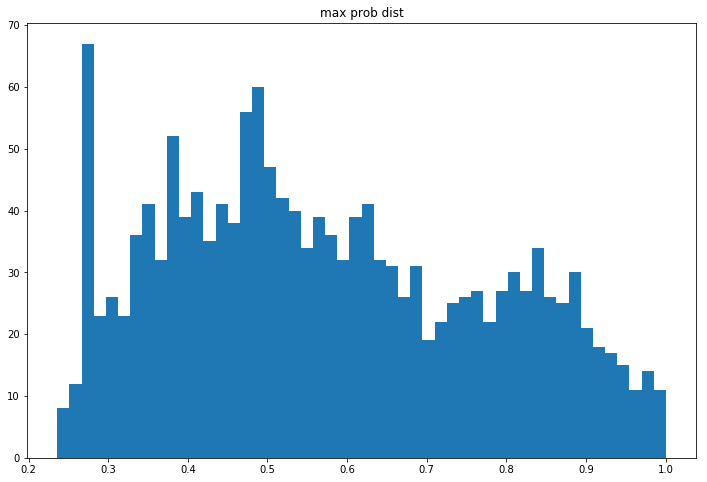

In [124]:
x = np.amax(scaled_calib_svc_probs, axis = 1)
plt.figure(figsize = (12, 8))
n, bins, patches = plt.hist(x, 50)
plt.title("max prob dist")
plt.show()

In [125]:
preds1 = clf_svc.predict(test_vectors)
preds2 = sig_clf_svc.predict(test_vectors)
print np.unique(preds1)
print np.unique(preds2)
print classification_report(test_labels,preds1)
print classification_report(test_labels,preds2)
print accuracy_score(test_labels,preds1)
print accuracy_score(test_labels,preds2)

[1 3 4 6 7]
[1 3 4 6 7]
             precision    recall  f1-score   support

          0       0.00      0.00      0.00       194
          1       0.26      0.64      0.37       206
          2       0.00      0.00      0.00       199
          3       0.38      0.74      0.51       187
          4       0.36      0.48      0.41       192
          5       0.00      0.00      0.00       200
          6       0.31      0.39      0.35       160
          7       0.55      0.55      0.55       211

avg / total       0.23      0.35      0.27      1549

             precision    recall  f1-score   support

          0       0.00      0.00      0.00       194
          1       0.27      0.51      0.36       206
          2       0.00      0.00      0.00       199
          3       0.48      0.70      0.57       187
          4       0.30      0.51      0.38       192
          5       0.00      0.00      0.00       200
          6       0.26      0.41      0.32       160
          7       

### To find the new class, we select a Percentile for Probability Threshold for Class Labels

In [126]:
class_prob_percentile_85 = np.array([np.percentile(scaled_calib_svc_probs[:,val], 85.0) 
                                     for val in range(len(scaled_calib_svc_probs[0]))])

test_class_preds = np.greater_equal(scaled_calib_svc_probs,class_prob_percentile_85).astype(int)

# Predict the test label based on percental
# If a data is below 80% for prob of all class, it belongs to open class
valid_class_probs = np.multiply(scaled_calib_svc_probs, test_class_preds)
valid_class = np.greater_equal(np.ceil(valid_class_probs),1).astype(int)
predicted_multinomial = np.multiply(valid_class, np.unique(train_final_labels))
predicted_test_class = np.max(predicted_multinomial,axis=1)

# The true unseen class index
unseen_class_indices = np.where(np.isin(test_labels, missing_class))[0]

In [127]:
print "predicted test classes", np.unique(predicted_test_class)
print "train labels", np.unique(train_final_labels)
print "Full list of original test labels", np.unique(orig_test_labels)

predicted test classes [0 1 3 4 6 7]
train labels [1 3 4 6 7]
Full list of original test labels [0 1 2 3 4 5 6 7]


In [128]:
import copy
orig_valid_labels = copy.copy(valid_final_labels)

missing_class_idx_test = np.where(np.isin(test_labels, missing_class))[0]
missing_class_idx_val = np.where(np.isin(valid_final_labels, missing_class))[0]

#print missing_class_idx_test
#orig_test_labels = copy.copy(test_labels)
for i in range(len(test_labels)): 
    if i in missing_class_idx_test:
        test_labels[i] = 0
        
for i in range(len(valid_final_labels)): 
    if i in missing_class_idx_val:
        valid_final_labels[i] = 0

In [129]:
print classification_report(test_labels, predicted_test_class)
print accuracy_score(test_labels, predicted_test_class)

             precision    recall  f1-score   support

          0       0.51      0.39      0.44       593
          1       0.35      0.39      0.37       206
          3       0.55      0.66      0.60       187
          4       0.40      0.42      0.41       192
          6       0.30      0.39      0.34       160
          7       0.52      0.57      0.55       211

avg / total       0.46      0.45      0.45      1549

0.450613298903


In [130]:
print np.bincount(sorted(predicted_test_class[unseen_class_indices]))
print sum(np.bincount(sorted(predicted_test_class[unseen_class_indices])))
print float(np.bincount(sorted(predicted_test_class[unseen_class_indices]))[0]), \
    sum(np.isin(test_labels, missing_class).astype(int))
print float(np.bincount(sorted(predicted_test_class[unseen_class_indices]))[0])/sum(np.isin(test_labels, \
                                                                                            missing_class).astype(int))

[230 133   0  71  62   0  58  39]
593
230.0 593
0.387858347386


## Clustering Method

In [131]:
import pandas as pd
import numpy as np

train_final_vectors = np.array(train_final_vectors)
valid_final_vectors=np.array(valid_final_vectors)
test_vectors=np.array(test_vectors)
print train_final_vectors.shape
print valid_final_vectors.shape
print test_vectors.shape


X = train_final_vectors
y = train_final_labels

X_val = valid_final_vectors
y_val = valid_final_labels

X_test = test_vectors
y_test = test_labels

feat_cols = [ 'col'+str(i) for i in range(X.shape[1]) ]
feat_cols_val = [ 'col'+str(i) for i in range(X_val.shape[1]) ]
feat_cols_test = [ 'col'+str(i) for i in range(X_test.shape[1]) ]

df = pd.DataFrame(X,columns=feat_cols)
df['label'] = y
df['label'] = df['label'].apply(lambda i: str(i))


df_val = pd.DataFrame(X_val,columns=feat_cols_val)
df_val['label'] = y_val
df_val['label'] = df_val['label'].apply(lambda i: str(i))

df_test = pd.DataFrame(X_test,columns=feat_cols_test)
df_test['label'] = y_test
df_test['label'] = df_test['label'].apply(lambda i: str(i))


X, y = None, None
print 'Size of the train dataframe: {}'.format(df.shape)
print 'Size of the test dataframe: {}'.format(df_val.shape)
print 'Size of the test dataframe: {}'.format(df_test.shape)

N = df.shape[0]
print N

(3103, 450)
(1239, 450)
(1549, 450)
Size of the train dataframe: (3103, 451)
Size of the test dataframe: (1239, 451)
Size of the test dataframe: (1549, 451)
3103


### Using Latent Semantic Analysis for dimension reduction

In [132]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
import logging
from optparse import OptionParser
import sys
from time import time
import numpy as np
from sklearn.decomposition import TruncatedSVD

print("Performing dimensionality reduction using LSA")
t0 = time()
svd = TruncatedSVD(n_components=20)
normalizer = Normalizer(copy=False)
lsa = make_pipeline(svd, normalizer)

lsa_result = lsa.fit_transform(df[feat_cols].values)
lsa_val = lsa.fit_transform(df_val[feat_cols].values)
lsa_test = lsa.transform(df_test[feat_cols_test].values)

print("done in %fs" % (time() - t0))

explained_variance = svd.explained_variance_ratio_.sum()
print("Explained variance of the SVD step: {}%".format(int(explained_variance * 100)))

Performing dimensionality reduction using LSA
done in 0.093847s
Explained variance of the SVD step: 69%


### Also try PCA for dimension reduction

In [133]:
from sklearn.decomposition import PCA

pca = PCA(n_components=20)
pca_result = pca.fit_transform(df[feat_cols].values)

df['pca-one'] = pca_result[:,0]
df['pca-two'] = pca_result[:,1] 
#df['pca-three'] = pca_result[:,2]
#df['pca-four'] = pca_result[:,3]
#df['pca-five'] = pca_result[:,4]


print 'Explained variation per principal component: {}'.format(pca.explained_variance_ratio_)
print 'Explained variation All components: {}'.format(sum(pca.explained_variance_ratio_))


Explained variation per principal component: [ 0.27525303  0.08254317  0.05819358  0.04140088  0.03538666  0.02235701
  0.02126207  0.0201448   0.01669327  0.01542604  0.01392297  0.013236
  0.01234412  0.0122098   0.01079311  0.01034703  0.00940974  0.00893931
  0.00850701  0.00797225]
Explained variation All components: 0.696341861039


** We will use LCA as it capture higher percentage of variation **

## Gaussian Mixture Models

### Fit Gaussian Mixture Models of varying components and covariance matrix sizes

In [134]:
import itertools
import operator
from scipy import linalg
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy

from sklearn import mixture
print(__doc__)


def GMM_fits(input_data=lsa_result, max_comp=21):
    # Number of samples per component
    n_samples = N
    # Generate random sample, two components
    np.random.seed(0)
    X = np.array(input_data)
    #X=np.array(pca_result_5)
    print X.shape

    bic_2 = {}
    n_components_range = range(max_comp, max_comp+1)
    cv_types = ['spherical', 'tied', 'diag', 'full']
    aic_dict = {}
    bic_dict = {}
    lowest_bic = np.infty
    lowest_aic = np.infty

    for cv_type in cv_types:

        bic = []
        aic = []
        for n_components in n_components_range:
            # Fit a Gaussian mixture with EM
            gmm = mixture.GaussianMixture(n_components=n_components,
                                          covariance_type=cv_type, 
                                          reg_covar =1e-3,
                                          random_state=0, 
                                          init_params='kmeans',
                                          max_iter = 1350)
            gmm.fit(X)
            bic.append(gmm.bic(X))
            aic.append(gmm.aic(X))
            bic_2[cv_type+"-" + str(n_components)] = gmm.bic(X)
            if bic[-1] < lowest_bic:
                lowest_bic = bic[-1]
                best_gmm = gmm
            if aic[-1] < lowest_aic:
                lowest_aic = aic[-1]

        aic_dict[cv_type] = aic
        bic_dict[cv_type] = bic

    clf = best_gmm
    sorted_bic_2 = sorted(bic_2.items(), key=operator.itemgetter(1))
    return clf, bic_dict, aic_dict, sorted_bic_2, lowest_bic, lowest_aic 

Automatically created module for IPython interactive environment


### Function to Plot AIC/BIC for model selection

In [135]:
def plot_model_selection_criteria(best_model, aic_dict, bic_dict, information_criteria = 'bic', max_comp = 21):
    n_components_range = range(1,max_comp)
    if information_criteria == 'bic':
        for cv in bic_dict.keys():
            plt.plot(n_components_range, bic_dict[cv], label=str(cv))
            #plt.plot(n_components, [m.aic(X) for m in models], label='AIC')
            plt.legend(loc=cv)
            plt.xlabel('n_components_range')
        plt.title("BIC plot")
    else:
        for cv in aic_dict.keys():
            plt.plot(n_components_range, aic_dict[cv], label=str(cv))
            #plt.plot(n_components, [m.aic(X) for m in models], label='AIC')
            plt.legend(loc=cv)
            plt.xlabel('n_components_range')
        plt.title("AIC plot")

In [137]:
num_train_class = 5
num_unseen_class =3
best_lsa_model,lsa_bic_d,lsa_aic_d,sorted_lsa_bic,lowest_lsa_aic,lowest_lsa_bic = GMM_fits(input_data=lsa_result, 
                                                                                            max_comp=num_train_class)

(3103, 20)


### Find the lowest AIC/BIC

In [138]:
print "Lowest_BIC", lowest_lsa_bic
print "Lowest_AIC", lowest_lsa_aic  
print "Best GMM Model Parameters based on BIC", best_lsa_model.get_params

Lowest_BIC -107346.606156
Lowest_AIC -100376.302294
Best GMM Model Parameters based on BIC <bound method GaussianMixture.get_params of GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=1350,
        means_init=None, n_components=5, n_init=1, precisions_init=None,
        random_state=0, reg_covar=0.001, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)>


### Make prediction using the lowest BIC

Homogeneity: 0.154
Completeness: 0.157
V-measure: 0.156
Adjusted Rand-Index: 0.126
Silhouette Coefficient: 0.069
fowlkes_mallows_score: 0.307


(array([ 467.,    0.,  591.,    0.,    0.,  927.,    0.,  540.,    0.,  578.]),
 array([ 0. ,  0.4,  0.8,  1.2,  1.6,  2. ,  2.4,  2.8,  3.2,  3.6,  4. ]),
 <a list of 10 Patch objects>)

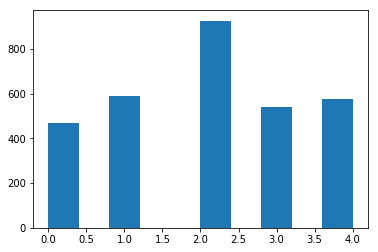

In [139]:
predicted_cluster = best_lsa_model.predict(lsa_result)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(df['label'], predicted_cluster))
print("Completeness: %0.3f" % metrics.completeness_score(df['label'], predicted_cluster))
print("V-measure: %0.3f" % metrics.v_measure_score(df['label'], predicted_cluster))
print("Adjusted Rand-Index: %.3f"
      % metrics.adjusted_rand_score(df['label'], predicted_cluster))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(lsa_result, predicted_cluster, sample_size=1000))
print ("fowlkes_mallows_score: %.3f"
      % metrics.fowlkes_mallows_score(df['label'], predicted_cluster))
plt.hist(predicted_cluster)

In [140]:
def print_cluster_comp(predicted_labels,actual_labels):
    Cluster_ids = {}
    for i in predicted_labels:
        Cluster_ids[i] = (predicted_labels==i).nonzero()[0]

    targets = np.array(actual_labels)
    #print Cluster_ids
    for label in Cluster_ids.keys():
        #print type(label)
        idx = Cluster_ids[label]
        print "Cluster Number", str(label), "Composition", np.bincount(targets[idx])
        print "\n"

In [141]:
print print_cluster_comp(predicted_labels=predicted_cluster, actual_labels=train_final_labels)

Cluster Number 0 Composition [  0  15   0  23 158   0  95 176]


Cluster Number 1 Composition [  0 319   0  43 100   0  90  39]


Cluster Number 2 Composition [  0 181   0 110 243   0 243 150]


Cluster Number 3 Composition [  0  30   0  85  76   0 151 198]


Cluster Number 4 Composition [  0  78   0 389  54   0  37  20]


None


### Validation Data Prediction

In [142]:
pred_proba_val_labels = best_lsa_model.predict_proba(lsa_val)

In [143]:
print pred_proba_val_labels
val_gmm_class_max_prob_lists = np.array([max(pred_proba_val_labels[:,val]) for val in range(len(pred_proba_val_labels[0]))])
val_gmm_class_min_prob_lists = np.array([min(pred_proba_val_labels[:,val]) for val in range(len(pred_proba_val_labels[0]))])
val_gmm_delta = val_gmm_class_max_prob_lists - val_gmm_class_min_prob_lists

print val_gmm_delta
# Normalized for test vector
scaled_gmm_val_class_probs = np.divide(pred_proba_val_labels,val_gmm_delta)
print scaled_gmm_val_class_probs

[[  2.89144507e-71   8.58728751e-06   4.95373851e-75   9.99991413e-01
    6.17593096e-51]
 [  1.27113047e-14   9.99982906e-01   4.02476343e-18   2.49846411e-09
    1.70914890e-05]
 [  4.88311516e-03   9.83287503e-01   1.60684576e-07   1.17003123e-02
    1.28909165e-04]
 ..., 
 [  2.29214498e-18   1.00000000e+00   1.83838224e-26   2.69227187e-14
    1.99240218e-11]
 [  9.99999962e-01   2.90570209e-23   3.81488888e-08   2.75605742e-31
    1.88182700e-20]
 [  1.77146484e-07   9.75725300e-02   2.06645480e-12   5.89161658e-01
    3.13265635e-01]]
[ 0.99999996  1.          1.          1.          1.        ]
[[  2.89144518e-71   8.58728751e-06   4.95373852e-75   9.99991413e-01
    6.17593096e-51]
 [  1.27113052e-14   9.99982906e-01   4.02476344e-18   2.49846411e-09
    1.70914890e-05]
 [  4.88311534e-03   9.83287503e-01   1.60684577e-07   1.17003123e-02
    1.28909165e-04]
 ..., 
 [  2.29214507e-18   1.00000000e+00   1.83838224e-26   2.69227187e-14
    1.99240218e-11]
 [  1.00000000e+00   2.

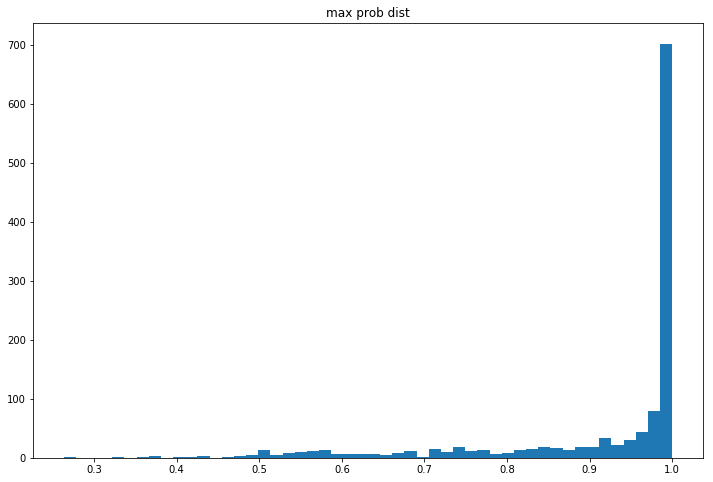

In [144]:
x = np.amax(pred_proba_val_labels, axis = 1)
#print pred_proba_test_labels[:,0]
plt.figure(figsize = (12, 8))
n, bins, patches = plt.hist(x, 50)
plt.title("max prob dist")
plt.show()

In [145]:
class_threshold = 85.0
val_gmm_class_prob_percentile_cutoff = np.array([np.percentile(scaled_gmm_val_class_probs[:,val], class_threshold) 
                                     for val in range(len(scaled_gmm_val_class_probs[0]))])

print val_gmm_class_prob_percentile_cutoff

gmm_val_class_preds = np.greater_equal(scaled_gmm_val_class_probs,val_gmm_class_prob_percentile_cutoff).astype(int)

print scaled_gmm_val_class_probs
# Predict the test label based on percental
# If a data is below 80% for prob of all class, it belongs to open class
val_gmm_valid_class_probs = np.multiply(scaled_gmm_val_class_probs, gmm_val_class_preds)
val_gmm_valid_class = np.greater_equal(np.ceil(val_gmm_valid_class_probs),1).astype(int)
print val_gmm_valid_class
val_gmm_predicted_multinomial = np.multiply(val_gmm_valid_class, np.unique(train_final_labels))
print np.unique(np.sum(val_gmm_predicted_multinomial, axis=1))
gmm_predicted_val_class = np.max(val_gmm_predicted_multinomial,axis=1)


[ 0.00956492  0.99945471  0.00102168  0.99967839  0.3318508 ]
[[  2.89144518e-71   8.58728751e-06   4.95373852e-75   9.99991413e-01
    6.17593096e-51]
 [  1.27113052e-14   9.99982906e-01   4.02476344e-18   2.49846411e-09
    1.70914890e-05]
 [  4.88311534e-03   9.83287503e-01   1.60684577e-07   1.17003123e-02
    1.28909165e-04]
 ..., 
 [  2.29214507e-18   1.00000000e+00   1.83838224e-26   2.69227187e-14
    1.99240218e-11]
 [  1.00000000e+00   2.90570209e-23   3.81488889e-08   2.75605742e-31
    1.88182700e-20]
 [  1.77146490e-07   9.75725300e-02   2.06645481e-12   5.89161658e-01
    3.13265635e-01]]
[[0 0 0 1 0]
 [0 1 0 0 0]
 [0 0 0 0 0]
 ..., 
 [0 1 0 0 0]
 [1 0 0 0 0]
 [0 0 0 0 0]]
[ 0  1  3  4  5  6  7  8 11 12]


In [146]:
print np.bincount(valid_final_labels), np.bincount(gmm_predicted_val_class)
print np.sum(np.bincount(valid_final_labels)), np.sum(np.bincount(gmm_predicted_val_class))

[487 153   0 151 168   0 134 146] [424 115   0 186 142   0 186 186]
1239 1239


### Calculate Unseen Class Precision, Recall, F1 Score

In [147]:
print "Composition of gmm_predicted_valid_class for true unseen class indices", np.bincount(sorted(gmm_predicted_val_class[missing_class_idx_val]))
print sum(np.bincount(sorted(gmm_predicted_val_class[missing_class_idx_val])))

Composition of gmm_predicted_valid_class for true unseen class indices [156  60   0  50  84   0  78  59]
487


In [148]:
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score
print classification_report(gmm_predicted_val_class, valid_final_labels)
print confusion_matrix(gmm_predicted_val_class, valid_final_labels)

             precision    recall  f1-score   support

          0       0.32      0.37      0.34       424
          1       0.12      0.16      0.13       115
          3       0.08      0.06      0.07       186
          4       0.11      0.13      0.12       142
          6       0.11      0.08      0.09       186
          7       0.13      0.10      0.11       186

avg / total       0.18      0.19      0.19      1239

[[156  64  42  66  47  49]
 [ 60  18   4  11  11  11]
 [ 50  13  12  45  20  46]
 [ 84  13   6  19  13   7]
 [ 78  30  41   8  15  14]
 [ 59  15  46  19  28  19]]


In [149]:
def calculate_unseen_class_f1score(pred_class, true_class, unseen_class_id):
    predicted_zero_ind = (pred_class==unseen_class_id).nonzero()[0]
    predicted_nonzero_ind = (pred_class > unseen_class_id).nonzero()[0]
    #print np.bincount(true_class[predicted_zero_ind])[0]
    TP = np.bincount(true_class[predicted_zero_ind])[0]
    FP =  sum(np.bincount(true_class[predicted_zero_ind])) - TP
    FN =  np.bincount(true_class[predicted_nonzero_ind])[0]
    #print TP, FP, FN
    unseen_class_precision = float(TP)/(TP+FP)
    unseen_class_recall = float(TP)/(TP+FN)
    unseen_class_f1 = 2*unseen_class_precision*unseen_class_recall/(unseen_class_precision+unseen_class_recall)
    #print unseen_class_precision,unseen_class_recall,unseen_class_f1
    return unseen_class_precision, unseen_class_recall,unseen_class_f1
    
pr,re,f1 = calculate_unseen_class_f1score(gmm_predicted_val_class, np.array(valid_final_labels), 0)
print pr,re,f1

0.367924528302 0.320328542094 0.34248079034


In [150]:
best_threshold = 0.0
best_f1_score=0.0
for threshold in range(50,95):
    try:
        val_gmm_class_prob_percentile_cutoff = np.array([np.percentile(scaled_gmm_val_class_probs[:,val], float(threshold)) 
                                             for val in range(len(scaled_gmm_val_class_probs[0]))])

        #print val_gmm_class_prob_percentile_cutoff

        gmm_val_class_preds = np.greater_equal(scaled_gmm_val_class_probs,val_gmm_class_prob_percentile_cutoff).astype(int)

        #print scaled_gmm_val_class_probs
        # Predict the test label based on percental
        # If a data is below 80% for prob of all class, it belongs to open class
        val_gmm_valid_class_probs_dup = np.multiply(scaled_gmm_val_class_probs, gmm_val_class_preds)

        val_gmm_valid_class_max_probs = np.max(val_gmm_valid_class_probs_dup, axis=1)
        #print gmm_valid_class_max_probs
        #print type(gmm_valid_class_probs_dup),  type(gmm_valid_class_max_probs)
        val_temp = np.equal(val_gmm_valid_class_probs_dup , val_gmm_valid_class_max_probs.reshape(len(val_gmm_valid_class_max_probs),1))
        val_gmm_valid_class_probs=np.multiply(val_gmm_valid_class_probs_dup,val_temp)
        val_gmm_valid_class = np.greater_equal(np.ceil(val_gmm_valid_class_probs),1).astype(int)
        #print val_gmm_valid_class
        val_gmm_predicted_multinomial = np.multiply(val_gmm_valid_class, np.unique(train_final_labels))
        #print np.unique(np.sum(val_gmm_predicted_multinomial, axis=1))
        gmm_predicted_val_class = np.max(val_gmm_predicted_multinomial,axis=1)  
        print np.unique(gmm_predicted_val_class), np.unique(valid_final_labels)
        pr,re,f1 = calculate_unseen_class_f1score(gmm_predicted_val_class,valid_final_labels,0)
        print "Threshold: ",threshold, "F1 Score: ", f1 
        print "Actual Unseen Class", np.bincount(valid_final_labels)[0], "Predicted Unseen Class",np.bincount(gmm_predicted_val_class)[0]
        # Set the threshold so that not unseen class volume is actual unseen class volume in validation set
        unseen_class_ratio = float(np.bincount(gmm_predicted_val_class)[0])/np.bincount(valid_final_labels)[0]
        #overall_F1_score = f1_score(gmm_predicted_val_class, valid_final_labels)
        if f1 > best_f1_score and unseen_class_ratio < 1.1:

            best_f1_score = f1
            best_threshold = threshold
    except:
        print "Threshold Too Low. No unseen class prediction"
        

[1 3 4 6 7] [0 1 3 4 6 7]
Threshold Too Low. No unseen class prediction
[1 3 4 6 7] [0 1 3 4 6 7]
Threshold Too Low. No unseen class prediction
[1 3 4 6 7] [0 1 3 4 6 7]
Threshold Too Low. No unseen class prediction
[1 3 4 6 7] [0 1 3 4 6 7]
Threshold Too Low. No unseen class prediction
[1 3 4 6 7] [0 1 3 4 6 7]
Threshold Too Low. No unseen class prediction
[1 3 4 6 7] [0 1 3 4 6 7]
Threshold Too Low. No unseen class prediction
[1 3 4 6 7] [0 1 3 4 6 7]
Threshold Too Low. No unseen class prediction
[1 3 4 6 7] [0 1 3 4 6 7]
Threshold Too Low. No unseen class prediction
[1 3 4 6 7] [0 1 3 4 6 7]
Threshold Too Low. No unseen class prediction
[1 3 4 6 7] [0 1 3 4 6 7]
Threshold Too Low. No unseen class prediction
[1 3 4 6 7] [0 1 3 4 6 7]
Threshold Too Low. No unseen class prediction
[1 3 4 6 7] [0 1 3 4 6 7]
Threshold Too Low. No unseen class prediction
[1 3 4 6 7] [0 1 3 4 6 7]
Threshold Too Low. No unseen class prediction
[1 3 4 6 7] [0 1 3 4 6 7]
Threshold Too Low. No unseen class pre

### Test Data Prediction

In [151]:
pred_proba_test_labels = best_lsa_model.predict_proba(lsa_test)

In [152]:
print pred_proba_test_labels
gmm_class_max_prob_lists = np.array([max(pred_proba_test_labels[:,val]) for val in range(len(pred_proba_test_labels[0]))])
gmm_class_min_prob_lists = np.array([min(pred_proba_test_labels[:,val]) for val in range(len(pred_proba_test_labels[0]))])
gmm_delta = gmm_class_max_prob_lists - gmm_class_min_prob_lists

print gmm_delta
# Normalized for test vector
scaled_gmm_test_class_probs = np.divide(pred_proba_test_labels,gmm_delta)
print scaled_gmm_test_class_probs

[[  1.09108802e-35   9.99999353e-01   4.95334985e-38   6.46567585e-07
    4.65011564e-25]
 [  5.01280960e-71   1.03909076e-04   1.37801071e-73   9.99896091e-01
    6.63194436e-50]
 [  5.25121773e-15   1.55848388e-10   1.00000000e+00   1.59708914e-22
    1.22478012e-10]
 ..., 
 [  1.25886232e-22   9.99965171e-01   2.85706149e-24   3.48292372e-05
    2.32028912e-15]
 [  9.99999962e-01   2.90570209e-23   3.81488888e-08   2.75605742e-31
    1.88182700e-20]
 [  2.01522419e-48   4.17769922e-08   4.28116259e-45   9.99999958e-01
    2.77892098e-27]]
[ 0.99999999  1.          1.          1.          1.        ]
[[  1.09108803e-35   9.99999353e-01   4.95334985e-38   6.46567585e-07
    4.65011564e-25]
 [  5.01280964e-71   1.03909076e-04   1.37801071e-73   9.99896091e-01
    6.63194436e-50]
 [  5.25121778e-15   1.55848388e-10   1.00000000e+00   1.59708914e-22
    1.22478012e-10]
 ..., 
 [  1.25886233e-22   9.99965171e-01   2.85706149e-24   3.48292372e-05
    2.32028912e-15]
 [  9.99999971e-01   2.

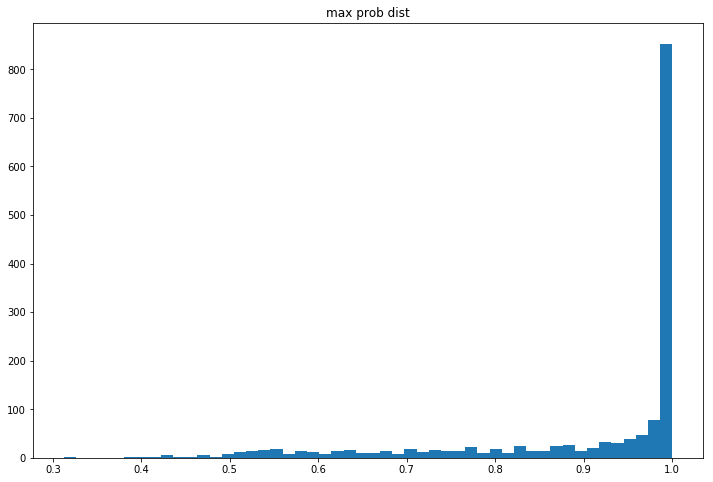

In [153]:
x = np.amax(pred_proba_test_labels, axis = 1)
#print pred_proba_test_labels[:,0]
plt.figure(figsize = (12, 8))
n, bins, patches = plt.hist(x, 50)
plt.title("max prob dist")
plt.show()

In [154]:
print best_threshold
gmm_class_prob_percentile_cutoff = np.array([np.percentile(scaled_gmm_test_class_probs[:,val], best_threshold) 
                                     for val in range(len(scaled_gmm_test_class_probs[0]))])

#print gmm_class_prob_percentile_cutoff

gmm_test_class_preds = np.greater_equal(scaled_gmm_test_class_probs,gmm_class_prob_percentile_cutoff).astype(int)

#print scaled_gmm_test_class_probs
# Predict the test label based on percental
# If a data is below 80% for prob of all class, it belongs to open class
gmm_valid_class_probs_dup = np.multiply(scaled_gmm_test_class_probs, gmm_test_class_preds)
print gmm_valid_class_probs_dup
gmm_valid_class_max_probs = np.max(gmm_valid_class_probs_dup, axis=1)
print gmm_valid_class_max_probs
#print type(gmm_valid_class_probs_dup),  type(gmm_valid_class_max_probs)
temp = np.equal(gmm_valid_class_probs_dup , gmm_valid_class_max_probs.reshape(len(gmm_valid_class_max_probs),1))
gmm_valid_class_probs=np.multiply(gmm_valid_class_probs_dup,temp)
gmm_valid_class = np.greater_equal(np.ceil(gmm_valid_class_probs),1).astype(int)
print gmm_valid_class
gmm_predicted_multinomial = np.multiply(gmm_valid_class, np.unique(train_final_labels))
print np.unique(np.sum(gmm_predicted_multinomial, axis=1))
gmm_predicted_test_class = np.max(gmm_predicted_multinomial,axis=1)

# The true unseen class index
#unseen_class_indices = np.where(np.isin(test_labels, missing_class))[0]

87
[[ 0.          0.99999935  0.          0.          0.        ]
 [ 0.          0.          0.          0.99989609  0.        ]
 [ 0.          0.          1.          0.          0.        ]
 ..., 
 [ 0.          0.99996517  0.          0.          0.        ]
 [ 0.99999997  0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.99999996  0.        ]]
[ 0.99999935  0.99989609  1.         ...,  0.99996517  0.99999997
  0.99999996]
[[0 1 0 0 0]
 [0 0 0 1 0]
 [0 0 1 0 0]
 ..., 
 [0 1 0 0 0]
 [1 0 0 0 0]
 [0 0 0 1 0]]
[0 1 3 4 6 7]


In [155]:
print np.bincount(test_labels), np.bincount(gmm_predicted_test_class)
print np.sum(np.bincount(test_labels)), np.sum(np.bincount(gmm_predicted_test_class))

[593 206   0 187 192   0 160 211] [638 170   0 202 135   0 202 202]
1549 1549


In [156]:
print confusion_matrix(test_labels, gmm_predicted_test_class)

[[239  80  56  72  84  62]
 [ 75  33  15  23  28  32]
 [ 68   8  13   6  45  47]
 [ 90  22  41  16  14   9]
 [ 84  14  18   9  13  22]
 [ 82  13  59   9  18  30]]


In [157]:
print classification_report(test_labels, gmm_predicted_test_class)
print accuracy_score(test_labels, gmm_predicted_test_class)

             precision    recall  f1-score   support

          0       0.37      0.40      0.39       593
          1       0.19      0.16      0.18       206
          3       0.06      0.07      0.07       187
          4       0.12      0.08      0.10       192
          6       0.06      0.08      0.07       160
          7       0.15      0.14      0.15       211

avg / total       0.22      0.22      0.22      1549

0.222078760491


### Unseen Class Precision, Recall F1 Score

In [158]:
print "Unseen Class Precision: ", calculate_unseen_class_f1score(gmm_predicted_test_class,test_labels,0)[0]
print "Unseen Class Recall: ", calculate_unseen_class_f1score(gmm_predicted_test_class,test_labels,0)[1]
print "Unseen Class F1 Score: ", calculate_unseen_class_f1score(gmm_predicted_test_class,test_labels,0)[2]

Unseen Class Precision:  0.37460815047
Unseen Class Recall:  0.403035413153
Unseen Class F1 Score:  0.388302193339


In [159]:
pred_class_indices = (gmm_predicted_test_class==0).nonzero()[0]

In [160]:
print("Homogeneity: %0.3f" % metrics.homogeneity_score(df_test['label'], gmm_predicted_test_class))
print("Completeness: %0.3f" % metrics.completeness_score(df_test['label'], gmm_predicted_test_class))
print("V-measure: %0.3f" % metrics.v_measure_score(df_test['label'], gmm_predicted_test_class))
print("Adjusted Rand-Index: %.3f"
      % metrics.adjusted_rand_score(df_test['label'], gmm_predicted_test_class))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(lsa_test, gmm_predicted_test_class, sample_size=1000))
print ("fowlkes_mallows_score: %.3f"
      % metrics.fowlkes_mallows_score(df_test['label'], gmm_predicted_test_class))

Homogeneity: 0.034
Completeness: 0.035
V-measure: 0.034
Adjusted Rand-Index: 0.005
Silhouette Coefficient: 0.007
fowlkes_mallows_score: 0.235


### Further Clustering Unsee Class

In [161]:
predicted_unseen_class_lsa= lsa_test[pred_class_indices]

fowlkes_mallows_score: 0.355


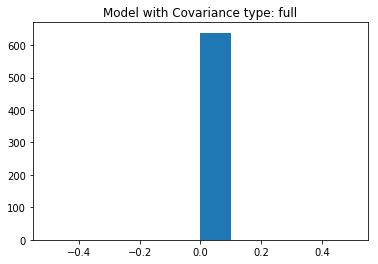

fowlkes_mallows_score: 0.355


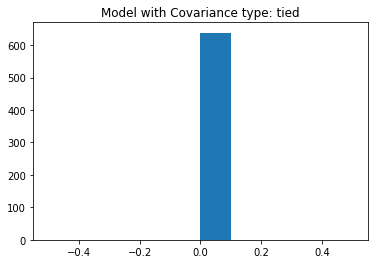

fowlkes_mallows_score: 0.355


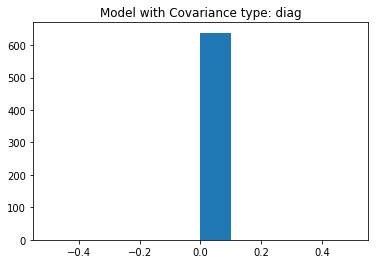

fowlkes_mallows_score: 0.355


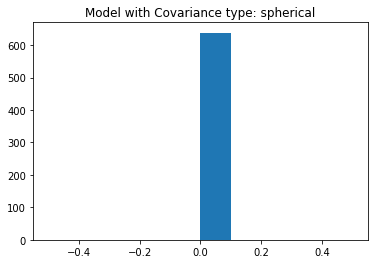

In [162]:
from sklearn.mixture import BayesianGaussianMixture

c_var = ['full', 'tied', 'diag', 'spherical']
n_components=1
models = [BayesianGaussianMixture(n_components, covariance_type=c, init_params='random').fit(predicted_unseen_class_lsa)
          for c in c_var]

for m in range(len(models)):
    plt.title("Model with Covariance type: " + str(c_var[m]))
    plt.hist(models[m].predict(predicted_unseen_class_lsa))
    pred_ls = models[m].predict(predicted_unseen_class_lsa)
    print ("fowlkes_mallows_score: %.3f"
      % metrics.fowlkes_mallows_score(pred_ls, orig_test_labels[pred_class_indices]))
    plt.show()
#gmm2_model.

## Infinite Dirichlet Process

In [163]:
def BGMM_fits(input_data=lsa_result, cv_type='full', max_comp=21):
    mod = BayesianGaussianMixture(n_components=max_comp, covariance_type='full', 
                                  weight_concentration_prior_type="dirichlet_process", 
                                  reg_covar=0, init_params='random',
        max_iter=1500, mean_precision_prior=.8,random_state=0)
    X = np.array(input_data)
    mod.fit(X)
    return mod

In [164]:
num_train_class = 5
num_unseen_class =2
best_lsa_model = BGMM_fits(input_data=lsa_result, max_comp=num_train_class)

In [165]:
print "Best IDP Model Parameters based on BIC", best_lsa_model.get_params

Best IDP Model Parameters based on BIC <bound method BayesianGaussianMixture.get_params of BayesianGaussianMixture(covariance_prior=None, covariance_type='full',
            degrees_of_freedom_prior=None, init_params='random',
            max_iter=1500, mean_precision_prior=0.8, mean_prior=None,
            n_components=5, n_init=1, random_state=0, reg_covar=0,
            tol=0.001, verbose=0, verbose_interval=10, warm_start=False,
            weight_concentration_prior=None,
            weight_concentration_prior_type='dirichlet_process')>


Homogeneity: 0.069
Completeness: 0.074
V-measure: 0.071
Adjusted Rand-Index: 0.065
Silhouette Coefficient: 0.059
fowlkes_mallows_score: 0.267


(array([ 127.,    0.,  778.,    0.,    0.,  695.,    0.,  815.,    0.,  688.]),
 array([ 0. ,  0.4,  0.8,  1.2,  1.6,  2. ,  2.4,  2.8,  3.2,  3.6,  4. ]),
 <a list of 10 Patch objects>)

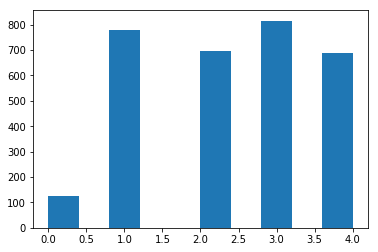

In [166]:
predicted_cluster = best_lsa_model.predict(lsa_result)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(df['label'], predicted_cluster))
print("Completeness: %0.3f" % metrics.completeness_score(df['label'], predicted_cluster))
print("V-measure: %0.3f" % metrics.v_measure_score(df['label'], predicted_cluster))
print("Adjusted Rand-Index: %.3f"
      % metrics.adjusted_rand_score(df['label'], predicted_cluster))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(lsa_result, predicted_cluster, sample_size=1000))
print ("fowlkes_mallows_score: %.3f"
      % metrics.fowlkes_mallows_score(df['label'], predicted_cluster))
plt.hist(predicted_cluster)

In [167]:
def print_cluster_comp(predicted_labels,actual_labels):
    Cluster_ids = {}
    for i in predicted_labels:
        Cluster_ids[i] = (predicted_labels==i).nonzero()[0]

    targets = np.array(actual_labels)
    #print Cluster_ids
    for label in Cluster_ids.keys():
        #print type(label)
        idx = Cluster_ids[label]
        print "Cluster Number", str(label), "Composition", np.bincount(targets[idx])
        print "\n"

In [168]:
pred_proba_val_labels = best_lsa_model.predict_proba(lsa_val)

In [169]:
print pred_proba_val_labels
val_gmm_class_max_prob_lists = np.array([max(pred_proba_val_labels[:,val]) for val in range(len(pred_proba_val_labels[0]))])
val_gmm_class_min_prob_lists = np.array([min(pred_proba_val_labels[:,val]) for val in range(len(pred_proba_val_labels[0]))])
val_gmm_delta = val_gmm_class_max_prob_lists - val_gmm_class_min_prob_lists

print val_gmm_delta
# Normalized for test vector
scaled_bgmm_val_class_probs = np.divide(pred_proba_val_labels,val_gmm_delta)
print scaled_bgmm_val_class_probs

[[  0.00000000e+000   0.00000000e+000   3.51689396e-144   1.00000000e+000
    8.30675887e-053]
 [  0.00000000e+000   0.00000000e+000   9.86993622e-002   9.01106994e-001
    1.93644262e-004]
 [  2.03265370e-239   3.45590933e-156   7.12975324e-001   2.86787668e-001
    2.37007690e-004]
 ..., 
 [  0.00000000e+000   0.00000000e+000   8.45298941e-001   1.54701043e-001
    1.60401914e-008]
 [  1.00000000e+000   4.71206321e-016   1.07706479e-037   3.53519379e-041
    3.12752230e-034]
 [  0.00000000e+000   2.46966340e-261   6.40950919e-008   9.98421723e-001
    1.57821320e-003]]
[  1.00000000e+00   1.82968508e-08   1.00000000e+00   1.00000000e+00
   1.00000000e+00]
[[  0.00000000e+000   0.00000000e+000   3.51689396e-144   1.00000000e+000
    8.30675887e-053]
 [  0.00000000e+000   0.00000000e+000   9.86993622e-002   9.01106994e-001
    1.93644262e-004]
 [  2.03265370e-239   1.88880007e-148   7.12975324e-001   2.86787668e-001
    2.37007690e-004]
 ..., 
 [  0.00000000e+000   0.00000000e+000   8.

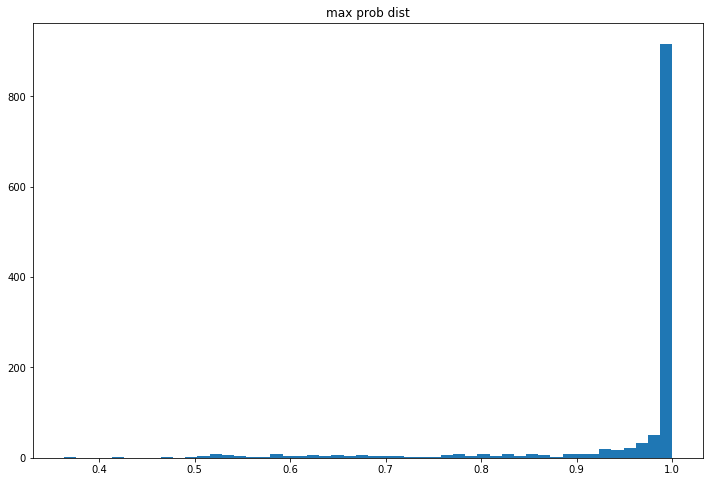

In [170]:
x = np.amax(pred_proba_val_labels, axis = 1)
#print pred_proba_test_labels[:,0]
plt.figure(figsize = (12, 8))
n, bins, patches = plt.hist(x, 50)
plt.title("max prob dist")
plt.show()

In [171]:
class_threshold = 85.0
val_bgmm_class_prob_percentile_cutoff = np.array([np.percentile(scaled_bgmm_val_class_probs[:,val], class_threshold) 
                                     for val in range(len(scaled_bgmm_val_class_probs[0]))])

print val_bgmm_class_prob_percentile_cutoff

bgmm_val_class_preds = np.greater_equal(scaled_bgmm_val_class_probs,val_bgmm_class_prob_percentile_cutoff).astype(int)

print scaled_bgmm_val_class_probs
# Predict the test label based on percental
# If a data is below 80% for prob of all class, it belongs to open class
val_bgmm_valid_class_probs = np.multiply(scaled_bgmm_val_class_probs, bgmm_val_class_preds)
val_bgmm_valid_class = np.greater_equal(np.ceil(val_bgmm_valid_class_probs),1).astype(int)
print val_bgmm_valid_class
val_bgmm_predicted_multinomial = np.multiply(val_bgmm_valid_class, np.unique(train_final_labels))
print np.unique(np.sum(val_bgmm_predicted_multinomial, axis=1))
bgmm_predicted_val_class = np.max(val_bgmm_predicted_multinomial,axis=1)

[  5.86428615e-271   2.12970984e-113   1.91396045e-001   1.00000000e+000
   9.90671861e-001]
[[  0.00000000e+000   0.00000000e+000   3.51689396e-144   1.00000000e+000
    8.30675887e-053]
 [  0.00000000e+000   0.00000000e+000   9.86993622e-002   9.01106994e-001
    1.93644262e-004]
 [  2.03265370e-239   1.88880007e-148   7.12975324e-001   2.86787668e-001
    2.37007690e-004]
 ..., 
 [  0.00000000e+000   0.00000000e+000   8.45298941e-001   1.54701043e-001
    1.60401914e-008]
 [  1.00000000e+000   2.57534111e-008   1.07706479e-037   3.53519379e-041
    3.12752230e-034]
 [  0.00000000e+000   1.34977512e-253   6.40950919e-008   9.98421723e-001
    1.57821320e-003]]
[[0 0 0 1 0]
 [0 0 0 0 0]
 [1 0 1 0 0]
 ..., 
 [0 0 1 0 0]
 [1 1 0 0 0]
 [0 0 0 0 0]]
[ 0  1  3  4  5  6  7  8 10 11]


In [172]:
print np.bincount(valid_final_labels), np.bincount(gmm_predicted_val_class)
print np.sum(np.bincount(valid_final_labels)), np.sum(np.bincount(gmm_predicted_val_class))

[487 153   0 151 168   0 134 146] [864  75   0  75  75   0  75  75]
1239 1239


## Calculate Unseen Class Precision, Recall, F1 Score

In [173]:
print "Composition of bgmm_predicted_valid_class for true unseen class indices", np.bincount(sorted(bgmm_predicted_val_class[missing_class_idx_val]))
print sum(np.bincount(sorted(gmm_predicted_val_class[missing_class_idx_val])))

Composition of bgmm_predicted_valid_class for true unseen class indices [177  31   0  46  90   0  86  57]
487


In [174]:
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score
print classification_report(bgmm_predicted_val_class, valid_final_labels)
print confusion_matrix(bgmm_predicted_val_class, valid_final_labels)

             precision    recall  f1-score   support

          0       0.36      0.35      0.35       513
          1       0.07      0.14      0.10        76
          3       0.05      0.09      0.07        92
          4       0.16      0.15      0.15       186
          6       0.11      0.08      0.09       186
          7       0.12      0.10      0.11       186

avg / total       0.22      0.21      0.21      1239

[[177  72  67  77  63  57]
 [ 31  11   4  13   7  10]
 [ 46  10   8  13   7   8]
 [ 90  11   9  27  16  33]
 [ 86  24  25  16  15  20]
 [ 57  25  38  22  26  18]]


In [175]:
def calculate_unseen_class_f1score(pred_class, true_class, unseen_class_id):
    predicted_zero_ind = (pred_class==unseen_class_id).nonzero()[0]
    predicted_nonzero_ind = (pred_class >unseen_class_id).nonzero()[0]
    #print np.bincount(true_class[predicted_zero_ind])[0]
    TP = np.bincount(true_class[predicted_zero_ind])[0]
    FP =  sum(np.bincount(true_class[predicted_zero_ind])) - TP
    FN =  np.bincount(true_class[predicted_nonzero_ind])[0]
    #print TP, FP, FN
    unseen_class_precision = float(TP)/(TP+FP)
    unseen_class_recall = float(TP)/(TP+FN)
    unseen_class_f1 = 2*unseen_class_precision*unseen_class_recall/(unseen_class_precision+unseen_class_recall)
    #print unseen_class_precision,unseen_class_recall,unseen_class_f1
    return unseen_class_precision, unseen_class_recall,unseen_class_f1
    
pr,re,f1 = calculate_unseen_class_f1score(bgmm_predicted_val_class,valid_final_labels,0)
print pr,re,f1

0.345029239766 0.363449691992 0.354


In [176]:
best_threshold = 0.0
best_f1_score=0.0
for threshold in range(50,95):
    try:
        val_bgmm_class_prob_percentile_cutoff = np.array([np.percentile(scaled_bgmm_val_class_probs[:,val], float(threshold)) 
                                             for val in range(len(scaled_bgmm_val_class_probs[0]))])

        #print val_gmm_class_prob_percentile_cutoff

        bgmm_val_class_preds = np.greater_equal(scaled_bgmm_val_class_probs,val_bgmm_class_prob_percentile_cutoff).astype(int)

        #print scaled_gmm_val_class_probs
        # Predict the test label based on percental
        # If a data is below 80% for prob of all class, it belongs to open class
        val_bgmm_valid_class_probs_dup = np.multiply(scaled_bgmm_val_class_probs, bgmm_val_class_preds)

        val_bgmm_valid_class_max_probs = np.max(val_bgmm_valid_class_probs_dup, axis=1)
        #print gmm_valid_class_max_probs
        #print type(gmm_valid_class_probs_dup),  type(gmm_valid_class_max_probs)
        val_temp = np.equal(val_bgmm_valid_class_probs_dup , val_bgmm_valid_class_max_probs.reshape(len(val_bgmm_valid_class_max_probs),1))
        val_bgmm_valid_class_probs=np.multiply(val_bgmm_valid_class_probs_dup,val_temp)
        val_bgmm_valid_class = np.greater_equal(np.ceil(val_bgmm_valid_class_probs),1).astype(int)
        #print val_gmm_valid_class
        val_bgmm_predicted_multinomial = np.multiply(val_bgmm_valid_class, np.unique(train_final_labels))
        #print np.unique(np.sum(val_gmm_predicted_multinomial, axis=1))
        bgmm_predicted_val_class = np.max(val_bgmm_predicted_multinomial,axis=1)  
        print np.unique(bgmm_predicted_val_class), np.unique(valid_final_labels)
        pr,re,f1 = calculate_unseen_class_f1score(bgmm_predicted_val_class,valid_final_labels,0)
        print "Threshold: ",threshold, "F1 Score: ", f1 
        print "Actual Unseen Class", np.bincount(valid_final_labels)[0], "Predicted Unseen Class",np.bincount(bgmm_predicted_val_class)[0]
        # Set the threshold so that not unseen class volume is actual unseen class volume in validation set
        unseen_class_ratio = float(np.bincount(bgmm_predicted_val_class)[0])/np.bincount(valid_final_labels)[0]
        #overall_F1_score = f1_score(gmm_predicted_val_class, valid_final_labels)
        if f1 > best_f1_score and unseen_class_ratio < 1.1:

            best_f1_score = f1
            best_threshold = threshold
    except:
        print "Threshold Too Low. No unseen class prediction"
        
print "Best Threshold: ", best_threshold
print "Best F1 Score: ", best_f1_score

[1 3 4 6 7] [0 1 3 4 6 7]
Threshold Too Low. No unseen class prediction
[1 3 4 6 7] [0 1 3 4 6 7]
Threshold Too Low. No unseen class prediction
[1 3 4 6 7] [0 1 3 4 6 7]
Threshold Too Low. No unseen class prediction
[1 3 4 6 7] [0 1 3 4 6 7]
Threshold Too Low. No unseen class prediction
[1 3 4 6 7] [0 1 3 4 6 7]
Threshold Too Low. No unseen class prediction
[1 3 4 6 7] [0 1 3 4 6 7]
Threshold Too Low. No unseen class prediction
[1 3 4 6 7] [0 1 3 4 6 7]
Threshold Too Low. No unseen class prediction
[1 3 4 6 7] [0 1 3 4 6 7]
Threshold Too Low. No unseen class prediction
[0 1 3 4 6 7] [0 1 3 4 6 7]
Threshold:  58 F1 Score:  0.00811359026369
Actual Unseen Class 487 Predicted Unseen Class 6
[0 1 3 4 6 7] [0 1 3 4 6 7]
Threshold:  59 F1 Score:  0.0120240480962
Actual Unseen Class 487 Predicted Unseen Class 12
[0 1 3 4 6 7] [0 1 3 4 6 7]
Threshold:  60 F1 Score:  0.0235756385069
Actual Unseen Class 487 Predicted Unseen Class 22
[0 1 3 4 6 7] [0 1 3 4 6 7]
Threshold:  61 F1 Score:  0.03082851

### Test Data Prediction

In [177]:
pred_proba_test_labels = best_lsa_model.predict_proba(lsa_test)

In [178]:
print pred_proba_test_labels
bgmm_class_max_prob_lists = np.array([max(pred_proba_test_labels[:,val]) for val in range(len(pred_proba_test_labels[0]))])
bgmm_class_min_prob_lists = np.array([min(pred_proba_test_labels[:,val]) for val in range(len(pred_proba_test_labels[0]))])
bgmm_delta = bgmm_class_max_prob_lists - bgmm_class_min_prob_lists

print bgmm_delta
# Normalized for test vector
scaled_bgmm_test_class_probs = np.divide(pred_proba_test_labels,bgmm_delta)
print scaled_bgmm_test_class_probs

[[  0.00000000e+000   0.00000000e+000   2.09445727e-078   1.00000000e+000
    3.12510209e-035]
 [  0.00000000e+000   0.00000000e+000   4.29714554e-138   1.00000000e+000
    7.42276162e-053]
 [  0.00000000e+000   3.04180292e-130   1.79115697e-017   3.67791630e-016
    1.00000000e+000]
 ..., 
 [  0.00000000e+000   0.00000000e+000   1.13983631e-029   1.00000000e+000
    2.73095555e-012]
 [  1.00000000e+000   4.71206321e-016   1.07706479e-037   3.53519379e-041
    3.12752230e-034]
 [  0.00000000e+000   0.00000000e+000   1.35039751e-094   1.00000000e+000
    2.16355363e-029]]
[  1.00000000e+00   6.08987076e-12   1.00000000e+00   1.00000000e+00
   1.00000000e+00]
[[  0.00000000e+000   0.00000000e+000   2.09445727e-078   1.00000000e+000
    3.12510209e-035]
 [  0.00000000e+000   0.00000000e+000   4.29714554e-138   1.00000000e+000
    7.42276162e-053]
 [  0.00000000e+000   4.99485628e-119   1.79115697e-017   3.67791630e-016
    1.00000000e+000]
 ..., 
 [  0.00000000e+000   0.00000000e+000   1.

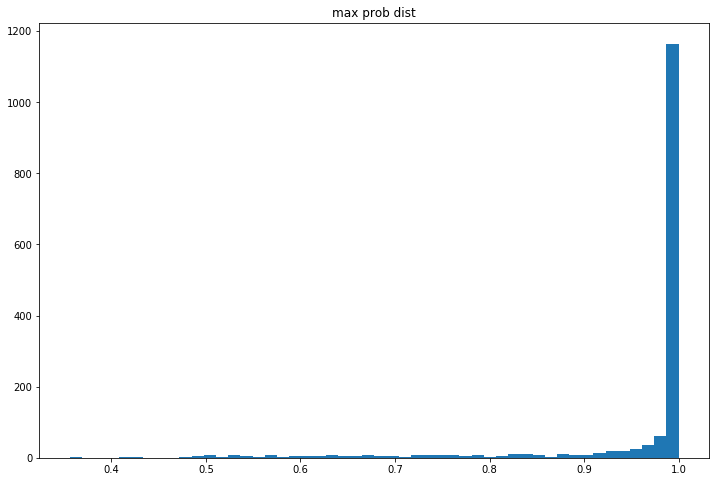

In [179]:
x = np.amax(pred_proba_test_labels, axis = 1)
#print pred_proba_test_labels[:,0]
plt.figure(figsize = (12, 8))
n, bins, patches = plt.hist(x, 50)
plt.title("max prob dist")
plt.show()

In [180]:
print best_threshold
bgmm_class_prob_percentile_cutoff = np.array([np.percentile(scaled_bgmm_test_class_probs[:,val], best_threshold) 
                                     for val in range(len(scaled_bgmm_test_class_probs[0]))])

#print gmm_class_prob_percentile_cutoff

bgmm_test_class_preds = np.greater_equal(scaled_bgmm_test_class_probs,bgmm_class_prob_percentile_cutoff).astype(int)

#print scaled_gmm_test_class_probs
# Predict the test label based on percental
# If a data is below 80% for prob of all class, it belongs to open class
bgmm_valid_class_probs_dup = np.multiply(scaled_bgmm_test_class_probs, bgmm_test_class_preds)
print bgmm_valid_class_probs_dup
bgmm_valid_class_max_probs = np.max(bgmm_valid_class_probs_dup, axis=1)
print bgmm_valid_class_max_probs
#print type(gmm_valid_class_probs_dup),  type(gmm_valid_class_max_probs)
temp = np.equal(bgmm_valid_class_probs_dup , bgmm_valid_class_max_probs.reshape(len(bgmm_valid_class_max_probs),1))
bgmm_valid_class_probs=np.multiply(bgmm_valid_class_probs_dup,temp)
bgmm_valid_class = np.greater_equal(np.ceil(bgmm_valid_class_probs),1).astype(int)
print bgmm_valid_class
bgmm_predicted_multinomial = np.multiply(bgmm_valid_class, np.unique(train_final_labels))
print np.unique(np.sum(bgmm_predicted_multinomial, axis=1))
bgmm_predicted_test_class = np.max(bgmm_predicted_multinomial,axis=1)

85
[[  0.00000000e+00   0.00000000e+00   0.00000000e+00   1.00000000e+00
    0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   1.00000000e+00
    0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    1.00000000e+00]
 ..., 
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  1.00000000e+00   7.73754222e-05   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   1.00000000e+00
    0.00000000e+00]]
[ 1.  1.  1. ...,  0.  1.  1.]
[[0 0 0 1 0]
 [0 0 0 1 0]
 [0 0 0 0 1]
 ..., 
 [0 0 0 0 0]
 [1 0 0 0 0]
 [0 0 0 1 0]]
[0 1 3 4 6 7]


In [181]:
print np.bincount(test_labels), np.bincount(bgmm_predicted_test_class)
print np.sum(np.bincount(test_labels)), np.sum(np.bincount(bgmm_predicted_test_class))
print confusion_matrix(test_labels, bgmm_predicted_test_class)

[593 206   0 187 192   0 160 211] [643 161   0  47 232   0 233 233]
1549 1549
[[235  65  21 106  94  72]
 [ 79  26   6  30  29  36]
 [ 74  12   5   7  36  53]
 [ 91  16   7  29  22  27]
 [ 72  18   4  18  20  28]
 [ 92  24   4  42  32  17]]


In [182]:
print classification_report(test_labels, bgmm_predicted_test_class)
print accuracy_score(test_labels, bgmm_predicted_test_class)

             precision    recall  f1-score   support

          0       0.37      0.40      0.38       593
          1       0.16      0.13      0.14       206
          3       0.11      0.03      0.04       187
          4       0.12      0.15      0.14       192
          6       0.09      0.12      0.10       160
          7       0.07      0.08      0.08       211

avg / total       0.21      0.21      0.21      1549

0.214331826985


## Unseen Class Precision, Recall F1 Score

In [183]:
print "Unseen Class Precision: ", calculate_unseen_class_f1score(bgmm_predicted_test_class,test_labels,0)[0]
print "Unseen Class Recall: ", calculate_unseen_class_f1score(bgmm_predicted_test_class,test_labels,0)[1]
print "Unseen Class F1 Score: ", calculate_unseen_class_f1score(bgmm_predicted_test_class,test_labels,0)[2]

Unseen Class Precision:  0.365474339036
Unseen Class Recall:  0.39629005059
Unseen Class F1 Score:  0.380258899676


In [98]:
pred_class_indices = (gmm_predicted_test_class==0).nonzero()[0]
print("Homogeneity: %0.3f" % metrics.homogeneity_score(df_test['label'], gmm_predicted_test_class))
print("Completeness: %0.3f" % metrics.completeness_score(df_test['label'], gmm_predicted_test_class))
print("V-measure: %0.3f" % metrics.v_measure_score(df_test['label'], gmm_predicted_test_class))
print("Adjusted Rand-Index: %.3f"
      % metrics.adjusted_rand_score(df_test['label'], gmm_predicted_test_class))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(lsa_test, gmm_predicted_test_class, sample_size=1000))
print ("fowlkes_mallows_score: %.3f"
      % metrics.fowlkes_mallows_score(df_test['label'], gmm_predicted_test_class))

Homogeneity: 0.013
Completeness: 0.016
V-measure: 0.014
Adjusted Rand-Index: 0.009
Silhouette Coefficient: 0.030
fowlkes_mallows_score: 0.273
